In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,precision_recall_curve, roc_curve, auc
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import bangla_nlp
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torchviz import make_dot

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
# Bangla Bert model
class CyberBullyingClassifier(nn.Module):
    def __init__(self):
        super(CyberBullyingClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        probability = self.sigmoid(logits)
        return probability

In [23]:
# Create model instance
model = CyberBullyingClassifier()
model.to(device)

CyberBullyingClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [24]:
model.load_state_dict(torch.load('G:/OneDrive - northsouth.edu/CODES/PROJECTS/PROJECT - Bullishield Models/Created Models/bangla_bert.pth'))

<All keys matched successfully>

In [25]:
df=pd.read_csv('Bengali hate speech .csv')
df.head()

,sentence,hate,category
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports


In [26]:
print("Hate-Non hate distribution")
df['hate'].value_counts()

Hate-Non hate distribution


hate
0    20000
1    10000
Name: count, dtype: int64

In [27]:
df_filtered=df[df['hate']==1]
print("Number of hate comments in every category")
df_filtered['category'].value_counts()

Number of hate comments in every category


category
crime                      2000
entertainment              1627
sports                     1601
religion                   1570
Meme, TikTok and others    1563
politics                    886
celebrity                   753
Name: count, dtype: int64

In [28]:

# remove punctuations
df['clean_punctuation']=df['sentence'].apply(bangla_nlp.clean_punctuations)
df['clean_emoji']=df['clean_punctuation'].apply(bangla_nlp.clean_emoji)
df['clean_text']=df['clean_emoji'].apply(bangla_nlp.clean_url_and_email)
df['clean_text']=df['clean_text'].apply(bangla_nlp.clean_digits)
drop_columns=['clean_punctuation','clean_emoji']
df.drop(columns=drop_columns,inplace=True)
df.head()


,sentence,hate,category,clean_text
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব


In [29]:
df['tokenized_words']=df['clean_text'].apply(bangla_nlp.word_tokenize_texts)
df.head()

,sentence,hate,category,clean_text,tokenized_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ..."


In [30]:
df['no_stopword_tokenized_words']=df['tokenized_words'].apply(bangla_nlp.remove_stopwords_from_tokens)
df.head()

,sentence,hate,category,clean_text,tokenized_words,no_stopword_tokenized_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]","[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]","[পাপন, শালা, রে, রিমান্ডে, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...","[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]","[শালা, লুচ্চা, পাঠার, মত, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ...","[তুই, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, খেলব..."


In [31]:
df['clean_string_words']=df['no_stopword_tokenized_words'].apply(' '.join)
df.head()

,sentence,hate,category,clean_text,tokenized_words,no_stopword_tokenized_words,clean_string_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]","[যত্তসব, পাপন, শালার, ফাজলামী]",যত্তসব পাপন শালার ফাজলামী
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]","[পাপন, শালা, রে, রিমান্ডে, দরকার]",পাপন শালা রে রিমান্ডে দরকার
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...","[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...",জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ একটা দে...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]","[শালা, লুচ্চা, পাঠার, মত, যায়]",শালা লুচ্চা পাঠার মত যায়
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ...","[তুই, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, খেলব...",তুই শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব


In [32]:
# Split into training and temp (validation + test)
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)  # 40% of data for temp

# Split temp into validation and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 50% of temp for each

In [33]:
# Tokenize the data
def tokenize_texts(texts, max_length):
    tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')
    tokenized_texts = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokenized_texts

max_length=128

train_tokenized_texts = tokenize_texts(train_data['clean_string_words'].tolist(), max_length)
test_tokenized_texts = tokenize_texts(test_data['clean_string_words'].tolist(), max_length)
val_tokenized_texts = tokenize_texts(val_data['clean_string_words'].tolist(), max_length)


In [34]:
print(train_tokenized_texts)

{'input_ids': tensor([[  101, 10273,  7724,  ...,     0,     0,     0],
        [  101, 76899, 19050,  ...,     0,     0,     0],
        [  101,  2390,  2097,  ...,     0,     0,     0],
        ...,
        [  101,  2181,  9294,  ...,     0,     0,     0],
        [  101,  2082,  6231,  ...,     0,     0,     0],
        [  101, 27024,  7724,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [35]:
# Prepare train and test inputs and labels
train_inputs = {
    'input_ids': train_tokenized_texts['input_ids'],
    'attention_mask': train_tokenized_texts['attention_mask']
}

train_labels = torch.tensor(train_data['hate'].values,dtype=torch.float32).unsqueeze(1)

test_inputs = {
    'input_ids': test_tokenized_texts['input_ids'],
    'attention_mask': test_tokenized_texts['attention_mask']
}

test_labels = torch.tensor(test_data['hate'].values,dtype=torch.float32).unsqueeze(1)

val_inputs = {
    'input_ids': val_tokenized_texts['input_ids'],
    'attention_mask': val_tokenized_texts['attention_mask']
}

val_labels = torch.tensor(val_data['hate'].values,dtype=torch.float32).unsqueeze(1)

In [36]:
def evaluate_model(model, inputs, labels, device, batch_size=32):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for i in range(0, len(inputs['input_ids']), batch_size):
            batch_inputs = {key: val[i:i+batch_size].to(device) for key, val in inputs.items()}
            batch_labels = labels[i:i+batch_size].to(device)

            # Get model output, assuming it returns logits or probabilities directly
            outputs = model(**batch_inputs)

            # Convert model outputs to predictions (assuming binary classification)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    preds = np.array(preds)
    true_labels = np.array(true_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, preds >= 0.5)
    precision = precision_score(true_labels, preds >= 0.5)
    recall = recall_score(true_labels, preds >= 0.5)
    f1 = f1_score(true_labels, preds >= 0.5)

    # Generate precision-recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(true_labels, preds)
    pr_auc = auc(recall_vals, precision_vals)

    # Generate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, preds)
    roc_auc = auc(fpr, tpr)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 5))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return accuracy, precision, recall, f1


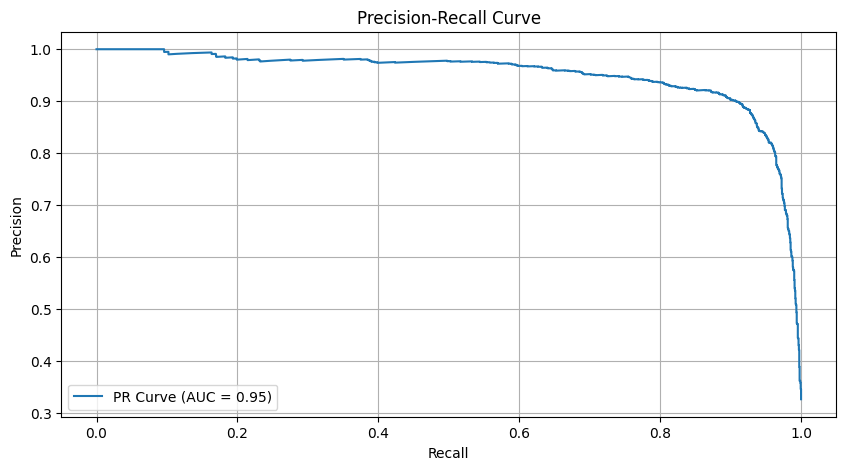

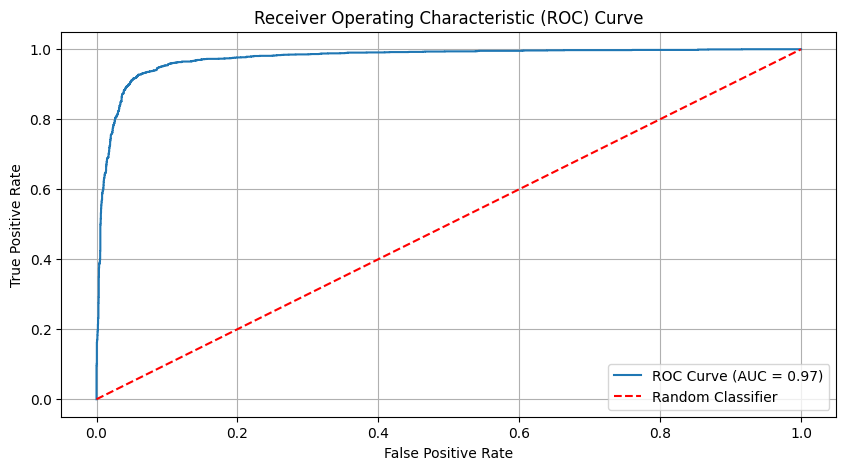

Validation Accuracy: 0.9362
Validation Precision: 0.8874
Validation Recall: 0.9214
Validation F1 Score: 0.9041


In [37]:
# Evaluate the model on the validation set
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_inputs, val_labels, device)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')


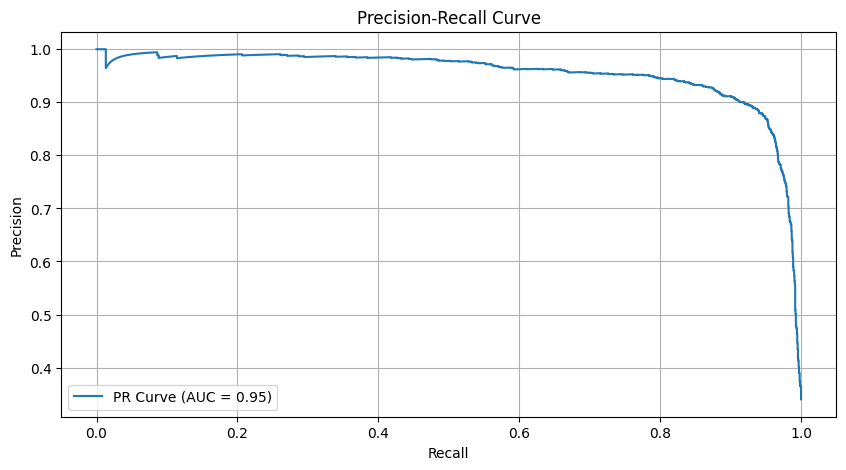

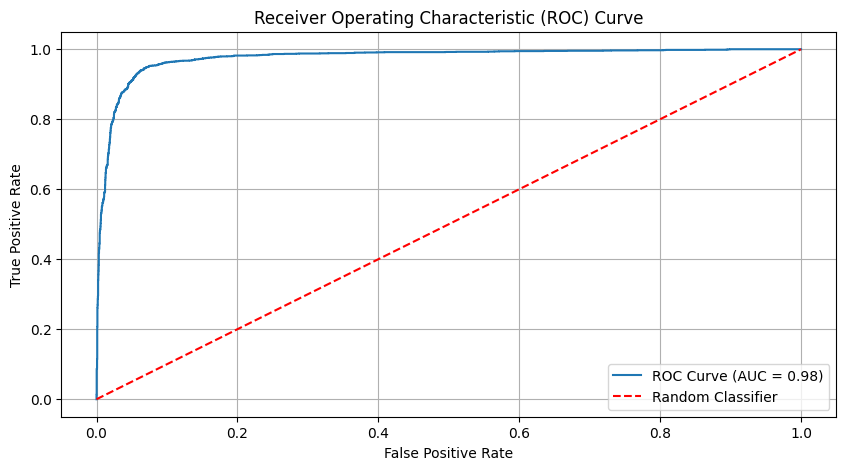

Test Accuracy: 0.9378
Test Precision: 0.8957
Test Recall: 0.9251
Test F1 Score: 0.9101


In [38]:
# Evaluate the model on the test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_inputs, test_labels, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')